In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from attention import Attention
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def read_data(file_location):
    df = pd.read_csv(file_location)
    return df

In [3]:
def preprocess_data(df, aggregation='H', ws=24, number_of_predicted_days=2):

    df.dropna(inplace=True)

    df.drop_duplicates(subset=['source_ts'], inplace=True)

    datetime_series = pd.to_datetime(df['source_ts'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df=df.set_index(datetime_index)
    df.drop('source_ts',axis=1,inplace=True)

    df=df.asfreq(freq='S', method='ffill')

    lastDay = df.index[-1].strftime('%Y-%m-%d')
    df = df.loc[:lastDay].iloc[:-1 , :]
    df

    prediction_in_future_time = ws * number_of_predicted_days
    
    df_resampled = df.resample(aggregation).sum()
    df_resampled

    df = df_resampled

    index_of_start_prediction = 0 - prediction_in_future_time
    day_of_start_prediction = df.index[index_of_start_prediction].strftime('%Y-%m-%d')
    index_of_end_train = index_of_start_prediction - ws
    day_of_end_train = df.index[index_of_end_train].strftime('%Y-%m-%d')

    TRAIN_END = day_of_end_train
    TEST_START = day_of_start_prediction

    training_set_df = df.loc[:TRAIN_END]

    test_set_df = df.loc[TEST_START:]

    return training_set_df, test_set_df

In [4]:
def create_model (shape):
    model = Sequential()
    
    model.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape=(shape,1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Attention(8))
    model.add(Dense(units=1))
    
    return model


In [5]:
def train_model(model, x_train, y_train, epochs=30, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    return model

In [6]:
def make_predictions(model, batch_one, prediction_in_future_time):
    prediction_test = []
    batch_new = batch_one.reshape((1, ws, 1))
    
    for _ in range(prediction_in_future_time):
        first_pred = model.predict(batch_new)[0]
        prediction_test.append(first_pred)
        batch_new = np.append(batch_new[:, 1:, :], [[first_pred]], axis=1)

    return np.array(prediction_test)


In [7]:
def evaluate_model(test_set, predictions):
    rmse = np.sqrt(mean_squared_error(test_set, predictions))
    rsquare = r2_score(test_set, predictions)
    return rmse, rsquare

In [8]:
def plot_results(test_set, predictions):
    plt.rcParams["figure.figsize"] = (40,3)
    plt.plot(test_set, color='green', label='Actual value')
    plt.plot(predictions, color='orange', label='Predicted value')
    plt.legend()
    plt.show()

In [9]:
def create_input_sequences(data, ws):
    x_train, y_train = [], []

    for i in range(ws, len(data)):
        x_train.append(data[i-ws:i, 0:1])
        y_train.append(data[i, 0])

    return np.array(x_train), np.array(y_train)

In [10]:
def main(file_location):
    df = read_data(file_location)

    training_set_df, test_set_df = preprocess_data(df)
    
    training_set = training_set_df.values
    test_set = test_set_df.values

    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    test_set_scaled = sc.fit_transform(test_set)

    x_train, y_train = create_input_sequences(training_set_scaled, ws)
    model = create_model(x_train.shape[1])
    
    model = train_model(model, x_train, y_train)

    batch_one = training_set_scaled[-ws:]
    predictions = make_predictions(model, batch_one, prediction_in_future_time)

    predictions = sc.inverse_transform(predictions)
    rmse, rsquare = evaluate_model(test_set, predictions)
    print("RMSE:", rmse)
    print("R-squared:", rsquare)
    
    plot_results(test_set, predictions)

Epoch 1/30
268/268 [==============================] - 25s 51ms/step - loss: 0.0034
Epoch 2/30
268/268 [==============================] - 9s 34ms/step - loss: 0.0026
Epoch 3/30
268/268 [==============================] - 9s 35ms/step - loss: 0.0023
Epoch 4/30
268/268 [==============================] - 9s 35ms/step - loss: 0.0022
Epoch 5/30
268/268 [==============================] - 9s 35ms/step - loss: 0.0020
Epoch 6/30
268/268 [==============================] - 9s 34ms/step - loss: 0.0019
Epoch 7/30
268/268 [==============================] - 9s 35ms/step - loss: 0.0019
Epoch 8/30
268/268 [==============================] - 9s 34ms/step - loss: 0.0019
Epoch 9/30
268/268 [==============================] - 9s 33ms/step - loss: 0.0019
Epoch 10/30
268/268 [==============================] - 9s 35ms/step - loss: 0.0018
Epoch 11/30
268/268 [==============================] - 9s 33ms/step - loss: 0.0019
Epoch 12/30
268/268 [==============================] - 9s 33ms/step - loss: 0.0018
Epoch 13/30


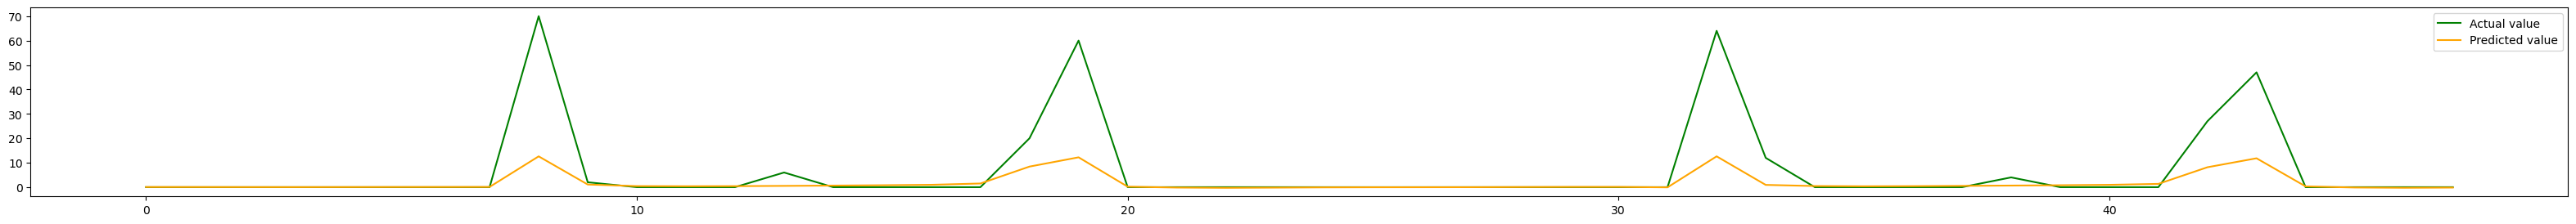

In [18]:
ws = 24
prediction_in_future_time = ws * 2
main("./testData/Dataset8.csv")